In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = np.load("drive/MyDrive/train_data.npy")
train_label = np.load("drive/MyDrive/train_label.npy")
test = np.load("drive/MyDrive/test_data.npy")
test_label = np.load("drive/MyDrive/test_label.npy")

In [4]:
train[:10, :]

array([[ -6.40101763,   2.72903876,   1.50171052, ...,   0.22933369,
         -0.1535829 ,   0.54404128],
       [  0.82978338,  -0.94994322,   6.0037526 , ...,   0.04319449,
         -0.0157158 ,  -0.28907615],
       [  7.73019978, -11.52210233,  -2.75362051, ...,   0.01458726,
         -0.35582987,   0.18428758],
       ...,
       [ -0.95665174,   4.98697009,  -1.85796096, ...,  -0.38416269,
         -0.26883811,   0.06904308],
       [  6.53338386,   2.32932422,   2.11608296, ...,   0.24489259,
          0.29264692,   0.09669723],
       [ -7.24712665,  -8.00795779,  -6.74123202, ...,   0.3548907 ,
         -0.38102421,   0.67609394]])

In [5]:
train.shape

(50000, 128)

In [6]:
train_label

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
#Define activation class
class Activation(object):
  def __relu(self, x):
    return np.maximum(x, 0)

  def __relu_deriv(self, a):
    # a = relu(x)
    a[a <= 0] = 0
    a[a > 0] = 1
    return a

  def __init__(self, activation = 'relu'):
    self.f = self.__relu
    self.f_deriv = self.__relu_deriv

In [8]:
#Define HiddenLayer
class HiddenLayers(object):
  def __init__(self, n_in, n_out, activation_last_layer = 'relu', activation = 'relu', W = None, b = None, miniBatch = None):
    self.input = None
    self.activation = Activation(activation).f

    #store momentum
    self.V_w = np.zeros_like(n_in)
    self.V_b = 0

    #miniBatSize
    self.miniBatch = 1 if not miniBatch else miniBatch

    #activation deriv of last layer
    self.activation_deriv = None
    if activation_last_layer:
      self.activation_deriv = Activation(activation_last_layer).f_deriv

    #Assign init values for weights
    self.W = np.random.uniform(
        low = -np.sqrt(6. / (n_in + n_out)),
        high = np.sqrt(6. / (n_in + n_out)),
        size = (n_in, n_out)
    )

    #Assign init values for bias
    self.b = np.zeros(n_out, )

    #Assign init values for gradations
    self.grad_W = np.zeros(self.W.shape)
    self.grad_b = np.zeros(self.b.shape)

  #the forward and backward progress for each training epoch
  def forward(self, input):
    '''
    input: np.array
    '''
    lin_output = np.dot(input, self.W) + self.b
    self.output = (
        lin_output if self.activation is None
        else self.activation(lin_output)
    )
    self.input = input
    return self.output

  def backward(self, delta, output_layer = False):
    self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)) / self.miniBatch
    if self.miniBatch != 1:
      self.grad_b = np.mean(delta.T, axis = 1)
    else:
      self.grad_b = delta
    if self.activation_deriv:
      delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
    return delta

In [56]:
#MLP
class MLP:
  #last layer is softmax
  def __init__(self, layers, activation = [None, 'relu', None], momentum = None, miniBatch = None, weightDecay = 0.0):
    '''
    layers: A list containing the number of units in each layer
    activatoin: the activation function to be used.
    momentum: A float number to determine if use momentum, what's the value of gamma
    MiniBatch: An int number to determine if use miniBatch, what's the size of batch
    weightDecay: An float number to determine the l2 penalty.
    '''
    #momentum param
    self.momentum = momentum

    #MiniBatch param
    self.miniBatch = miniBatch

    #WeightDecay param
    self.weightDecay = weightDecay

    #initialize layers
    self.layers = []
    self.params = []
    self.activation = activation
    for i in range(len(layers)-1):
      self.layers.append(HiddenLayers(layers[i], layers[i+1], activation[i], activation[i+1], miniBatch = self.miniBatch))

  #forward progress
  def forward(self, input):
    for layer in self.layers:
      output = layer.forward(input)
      input = output
    return self.softmax(output)

  #define the softmax and loss function
  def softmax(self, z):
    if len(z.shape) == 1:
      #SGD
      exp_z = np.exp(z - np.max(z))
      return exp_z / np.sum(exp_z)
    else:
      #Batch SGD
      exp_z = np.exp(z - np.max(z, axis = 1, keepdims = True))
      return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

  def cross_entropy_loss(self, y_hat, y):
    epsilon = 1e-15 #prevent log(0)
    #SGD
    if len(y.shape) == 1:
      loss = -np.sum(y * np.log(y_hat + epsilon))
    #MiniBatch
    else:
      loss = -np.mean(np.sum(y * np.log(y_hat + epsilon), axis = 1, keepdims = True))
    delta = y_hat - y

    #WeightDecay
    if self.weightDecay != 0:
      weight_decay_loss = 0
      for layer in self.layers:
        weight_decay_loss += 0.5 * self.weightDecay * np.sum(layer.W ** 2)
    return loss+weight_decay_loss, delta

    return loss, delta

  #backward progress
  def backward(self, delta):
    #output layer using softmax and cross-entropy
    for layer in reversed(self.layers):
      delta = layer.backward(delta)

  #update the weights
  #Using momentum
  def update(self, lr):
    if self.momentum:
      for layer in self.layers:
        V_w = self.momentum * layer.V_w + lr * (layer.grad_W + self.weightDecay * layer.W) #Weight Decay
        layer.V_w = V_w
        V_b = self.momentum * layer.V_b + lr * layer.grad_b
        layer.V_b = V_b
        layer.W -= V_w
        layer.b -= V_b
    else:
      for layer in self.layers:
        layer.W -= lr * (layer.grad_W + self.weightDecay * layer.W) #Weight Decay
        layer.b -= lr * layer.grad_b

  #define the training function
  def fit(self, X, y, learning_rate = 0.1, epochs = 100):
    """
    X: Input data
    y: Input targets
    learning_rate: the speed of learning
    epochs: number of times the dataset is presented to the network for learning
    """
    X = np.array(X)
    y = np.array(y)
    to_return_loss = np.zeros(epochs)
    to_return_accuracy = np.zeros(epochs)

    #SGD
    if not self.miniBatch:
      print("SGD")
      for k in range(epochs):
        loss = np.zeros(X.shape[0])
        correct = 0 #cal Accuracy
        for it in range(X.shape[0]):
          i = np.random.randint(X.shape[0])
          #forward
          y_hat = self.forward(X[i])

          #compute loss
          loss[it], delta = self.cross_entropy_loss(y_hat, y[i])
          #backward
          self.backward(delta)

          #updata
          self.update(learning_rate)

        #cal Accuracy
        predict = np.argmax(predict(X), axis = 1)
        for i in range(predict.shape[0]):
          if y[i, predict[i]] == 1:
            correct += 1

        to_return_loss[k] = np.mean(loss)
        to_return_accuracy[k] = correct/X.shape[0]
        print("iteration:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), correct/X.shape[0]))

    #MiniBatch SGD
    else:
      print("MiniBatch")
      for k in range(epochs):
        loss = np.zeros(int(X.shape[0]/self.miniBatch)+1)
        shuffled_indices = np.random.permutation(X.shape[0])
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        correct = 0 # cal Accuracy
        for it in range(0, X.shape[0], self.miniBatch):
          end_idx = min(it + self.miniBatch, X.shape[0])  #avoid index out of range
          Xi = X_shuffled[it:end_idx]
          yi = y_shuffled[it:end_idx]
          #forward
          y_hat = self.forward(Xi)
          #comput loss
          loss[int(it/self.miniBatch)], delta = self.cross_entropy_loss(y_hat, yi)
          #backward
          self.backward(delta)
          #update
          self.update(learning_rate)

        #cal Accuracy
        predict = np.argmax(self.predict(X), axis = 1)
        for i in range(predict.shape[0]):
          if y[i, predict[i]] == 1:
            correct += 1

        to_return_loss[k] = np.mean(loss)
        to_return_accuracy[k] = correct/X.shape[0]
        print("iteration:{0},loss:{1},Accuracy:{2}".format(k, np.mean(loss), correct/X.shape[0]))

    return to_return_loss, to_return_accuracy

  def predict(self, x):
    output = self.forward(x)
    return output


In [14]:
#translate train_label into input true value
train_real = np.zeros((train_label.shape[0], 10))
for i in range(train_label.shape[0]):
  train_real[i, train_label[i]] = 1
train_real.shape

(50000, 10)

In [11]:
train_real[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [57]:
#Learning
nn = MLP([128, 256, 128, 10], [None, "relu", "relu", None], momentum = 0.9, miniBatch = 4, weightDecay = 0.0001)
loss, accuracy  = nn.fit(train, train_real, learning_rate = 0.0001, epochs = 50)

MiniBatch
iteration:0,loss:1.897200097882459,Accuracy:0.40758
iteration:1,loss:1.671930008858107,Accuracy:0.45132
iteration:2,loss:1.5878685356355753,Accuracy:0.47594
iteration:3,loss:1.5267734840737308,Accuracy:0.49376
iteration:4,loss:1.477164332543069,Accuracy:0.5105
iteration:5,loss:1.437513131107168,Accuracy:0.5207
iteration:6,loss:1.4001934990445106,Accuracy:0.53402
iteration:7,loss:1.3699749908268573,Accuracy:0.54292
iteration:8,loss:1.3417283948959695,Accuracy:0.54884
iteration:9,loss:1.316813150606097,Accuracy:0.55612
iteration:10,loss:1.2930881922071042,Accuracy:0.57044
iteration:11,loss:1.2723392083530067,Accuracy:0.57426
iteration:12,loss:1.2501833860996692,Accuracy:0.5838
iteration:13,loss:1.233054812339916,Accuracy:0.5908
iteration:14,loss:1.2139646994181923,Accuracy:0.59898
iteration:15,loss:1.196565292295494,Accuracy:0.60628
iteration:16,loss:1.1809151007628367,Accuracy:0.61214
iteration:17,loss:1.1635759736672702,Accuracy:0.61668
iteration:18,loss:1.148269178625889,Acc

In [58]:
#Learning
nn2 = MLP([128, 256, 128, 10], [None, "relu", "relu", None], momentum = 0.9, miniBatch = 64, weightDecay = 0.0001)
loss2, accuracy2  = nn2.fit(train, train_real, learning_rate = 0.0001, epochs = 50)

MiniBatch
iteration:0,loss:2.2421969140936198,Accuracy:0.2413
iteration:1,loss:2.0760469378558923,Accuracy:0.29226
iteration:2,loss:1.9848834175729877,Accuracy:0.32236
iteration:3,loss:1.923365877999776,Accuracy:0.34022
iteration:4,loss:1.8787505053673743,Accuracy:0.35418
iteration:5,loss:1.844773602901425,Accuracy:0.36388
iteration:6,loss:1.8171877060752892,Accuracy:0.37388
iteration:7,loss:1.794187864167027,Accuracy:0.38092
iteration:8,loss:1.7742345888381417,Accuracy:0.3884
iteration:9,loss:1.7565601798167982,Accuracy:0.3943
iteration:10,loss:1.7407256834333245,Accuracy:0.40058
iteration:11,loss:1.7261821069432977,Accuracy:0.40564
iteration:12,loss:1.712912947939498,Accuracy:0.41106
iteration:13,loss:1.700767916316978,Accuracy:0.41508
iteration:14,loss:1.689469956372121,Accuracy:0.41932
iteration:15,loss:1.678920474513963,Accuracy:0.42296
iteration:16,loss:1.668837980888171,Accuracy:0.42754
iteration:17,loss:1.6592010094032845,Accuracy:0.42972
iteration:18,loss:1.6504972461848706,Ac

In [35]:
train

array([[ -6.40101763,   2.72903876,   1.50171052, ...,   0.22933369,
         -0.1535829 ,   0.54404128],
       [  0.82978338,  -0.94994322,   6.0037526 , ...,   0.04319449,
         -0.0157158 ,  -0.28907615],
       [  7.73019978, -11.52210233,  -2.75362051, ...,   0.01458726,
         -0.35582987,   0.18428758],
       ...,
       [  0.70734659, -11.34252124,  -0.39391488, ...,  -0.49020993,
         -0.21487252,  -0.03641533],
       [ 11.36790901,  -3.37597765,   5.56619766, ...,  -0.63245635,
         -0.07775427,   0.56149881],
       [  4.19279645,  -1.18418848,  -4.44596297, ...,  -0.04935812,
          0.16881497,   0.07433337]])

In [36]:
train_output = nn.predict(train)

In [37]:
predict = np.argmax(train_output, axis = 1)

In [38]:
correct = 0
for i in range(train_label.shape[0]):
  if train_label[i] == predict[i]:
    correct += 1
correct / train_label.shape[0]

0.99342

In [64]:
test_output = nn2.predict(test)

In [65]:
predict = np.argmax(test_output, axis = 1)

In [66]:
correct = 0
for i in range(test_label.shape[0]):
  if test_label[i] == predict[i]:
    correct += 1
correct / test_label.shape[0]

0.4799

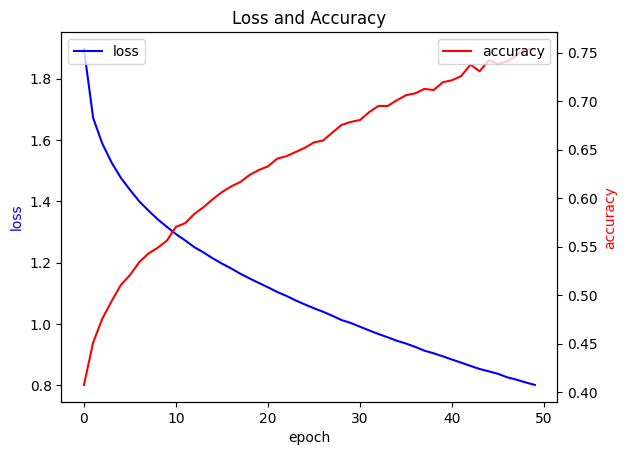

In [59]:
print_output(loss, accuracy)

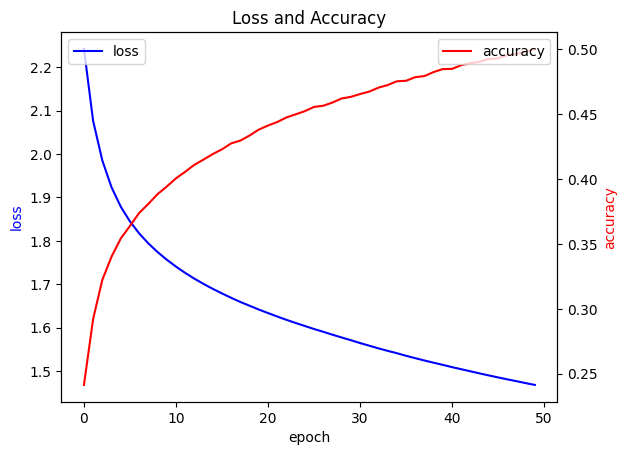

In [60]:
print_output(loss2, accuracy2)

In [52]:
def print_output(loss, accuracy):
  fig, ax1 = plt.subplots()

  # 绘制第一条线（主坐标轴）
  ax1.plot(loss, color='blue', label='loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss', color='blue')

  # 创建副坐标轴
  ax2 = ax1.twinx()

  # 绘制第二条线（副坐标轴）
  ax2.plot(accuracy, color='red', label='accuracy')
  ax2.set_ylabel('accuracy', color='red')

  # 添加标题和图例
  plt.title('Loss and Accuracy')
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  # 显示图表
  plt.show()